In [12]:
import os
from ast import literal_eval

import pandas as pd
import numpy as np

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

import json
import ast

from pathlib import Path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Task

detect and classify cuneiform characters on cuneiform 2d images

### Dataset:

1. 2d whole tablet images
2. segmentation file with bounding box for the obverse and reverse view of the tablet.
3. annotation file with bounding box for every sign on the 2d tablet
4. 113 total images (71 whole tablet images): 90 train, 23 test
    4.1 251 unique signs, 30 most appearing signs chosen
5. Augmentation of train set done (slight rotation, stretching vertical, horizontal, image sharpness): 270 augmented images + 90 original train
    5.1 No improvement in mAP scores
6. Anchor boxes for train set calculated and passed on to training
7. Faster RCNN model.
8. mAP, AP for each class used for evaluation

1. smaller signs are building blocks for larger signs
2. damage on tablet
3. same signs have slightly different aspect ratios
4. different writing styles as it covers 2000 years of cuneiform writing system
5. overlapping bounding boxes (not enough space between characters horizontally and vertically)

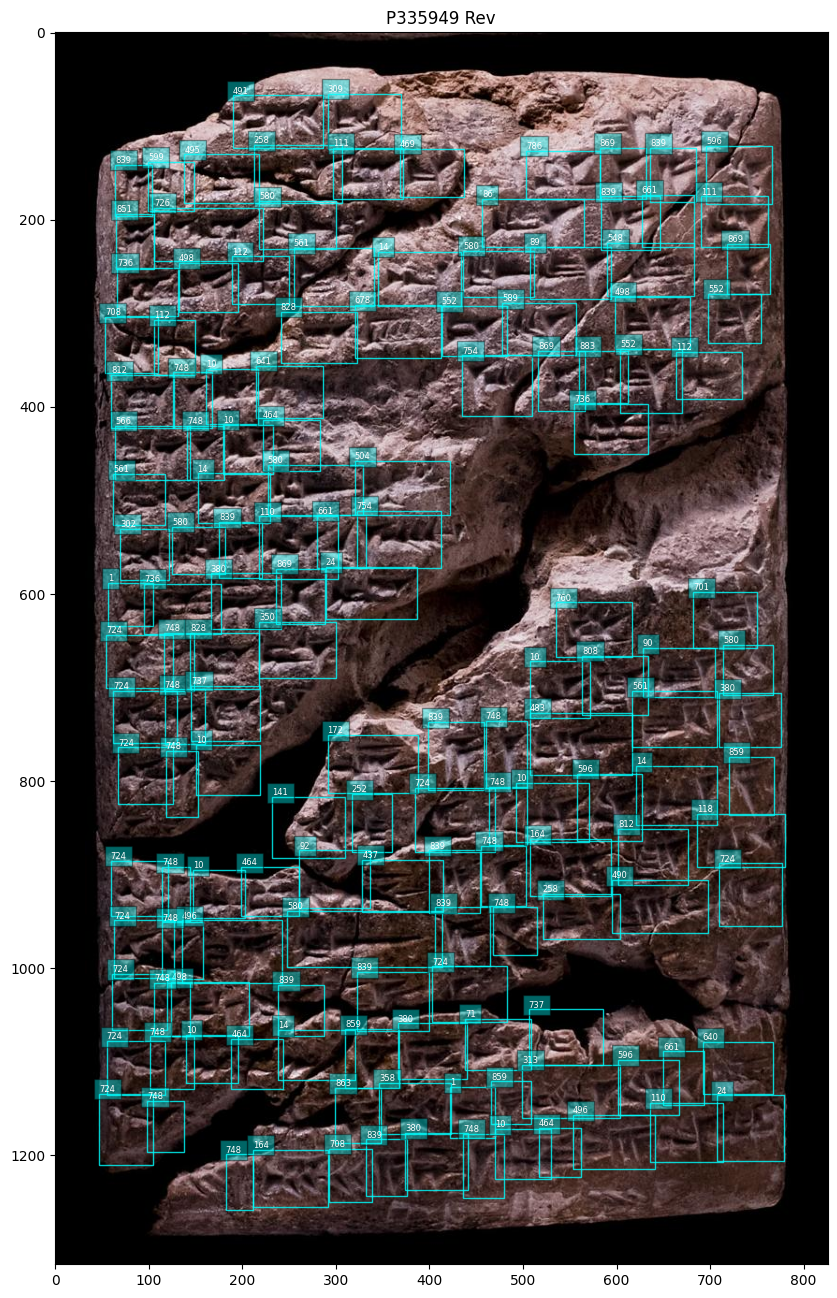

In [ ]:
#view_annotation(anno_df, seg_df, selected_cdli)

In [ ]:
seg_df = pd.read_csv('./71_segments.csv')
anno_df = pd.read_csv('./bbox_71_annotations.csv')
# convert bbox and relative bbox to np array
anno_df.bbox = anno_df.bbox.apply(literal_eval).apply(np.array)
anno_df.relative_bbox = anno_df.relative_bbox.apply(literal_eval).apply(np.array)
# convert bbox to np array
seg_df.bbox = seg_df.bbox.apply(literal_eval).apply(np.array)
# remove unassigned segments
seg_df = seg_df[seg_df.assigned]

In [16]:
seg_df['img_name'] = seg_df['tablet_CDLI'] + '_' + seg_df['view_desc']
anno_df['img_name'] = anno_df['tablet_CDLI'] + '_' + anno_df['view_desc']

In [17]:
duplicates = seg_df[seg_df.duplicated('img_name', keep=False)]
to_remove = duplicates[duplicates['collection'] != 'train']

columns_to_match = ['img_name', 'collection'] 
seg_df = seg_df.merge(to_remove[columns_to_match], on=columns_to_match, how='left', indicator=True)
seg_df = seg_df[seg_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [18]:
#seg_df.to_csv('./final_setup/segments.csv', index=False)
#anno_df.to_csv('./final_setup/annotations.csv', index=False)

# Split Tablet images into obverse and reverse sections, 71 images turn into 118 images

In [207]:
# for selected_cdli in seg_df['tablet_CDLI'].unique():
#     seg_df_slice = seg_df[seg_df.tablet_CDLI.isin([selected_cdli])]

#     for i, (si, s_rec) in enumerate(seg_df_slice.iterrows()):
#         path_to_image = './final_setup/raw/{}.jpg'.format(s_rec.tablet_CDLI)
#         pil_im = Image.open(path_to_image)
#         tablet_seg = crop_segment_from_image(pil_im, s_rec.bbox)
#         tablet_seg.save(os.path.join('./final_setup/obv_rev_split', s_rec.tablet_CDLI + '_' + s_rec.view_desc + '.jpg'))


In [208]:
anno_df.head(1)

segm_idx tablet_CDLI view_desc collection  mzl_label  train_label  \
0         8      K08396       Obv       test        252           80   

                   bbox         relative_bbox    img_name  
0  [910, 738, 978, 787]  [504, 655, 572, 704]  K08396_Obv

In [209]:
seg_df.head(1)

segm_idx tablet_CDLI view_desc collection                  bbox  scale  \
0       363     P334921       Obv      saa05  [638, 49, 1017, 635]   2.24   

   assigned     img_name  
0      True  P334921_Obv

# View annotations for given image

In [5]:
def crop_segment_from_image(im, bb):
    return im.crop((bb[0], bb[1], bb[2], bb[3]))

def plot_boxes(boxes, labels, ax=None):
    # setup figure if necessary
    if ax is None:
       fig, ax = plt.subplots(figsize=(15, 12))
    # iterate over bounding boxes
    for ii, bbox in enumerate(boxes):
        # plot box
        #print(bbox)
        #print(labels[ii])
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='cyan', alpha=0.8, linewidth=1.0)) 
        # plot label
        ax.text(bbox[0], bbox[1] - 2, '{}'.format(labels[ii]), bbox=dict(facecolor='cyan', alpha=0.4), fontsize=6, color='white')

Use the img_num from modelling and plug in the corresponding cdli num into selected_cdli

[
  {"id": 0, "file_name": "K08396_Obv.jpg"},

  {"id": 1, "file_name": "P336150_Obv.jpg"},

  {"id": 2, "file_name": "P336128_Rev.jpg"},

  {"id": 3, "file_name": "K08396_Rev.jpg"},

  {"id": 4, "file_name": "P334932_Rev.jpg"},

  {"id": 5, "file_name": "P335940_Rev.jpg"},

  {"id": 6, "file_name": "P335949_Rev.jpg"},
  
  {"id": 7, "file_name": "P335976_Obv.jpg"},

  {"id": 8, "file_name": "P336188_Obv.jpg"},

  {"id": 9, "file_name": "P336009_Rev.jpg"},

  {"id": 10, "file_name": "P335597_Obv.jpg"},

  {"id": 11, "file_name": "P335959_Obv.jpg"},

  {"id": 12, "file_name": "P334896_Obv.jpg"},

  {"id": 13, "file_name": "P334892_Rev.jpg"},

  {"id": 14, "file_name": "P334848_Rev.jpg"},

  {"id": 15, "file_name": "P336178_Obv.jpg"},

  {"id": 16, "file_name": "P336608_Obv.jpg"},

  {"id": 17, "file_name": "P336608_Rev.jpg"},

  {"id": 18, "file_name": "P336614_Obv.jpg"},

  {"id": 19, "file_name": "P334357_Rev.jpg"},

  {"id": 20, "file_name": "P336716_Obv.jpg"},

  {"id": 21, "file_name": "P334828_Obv.jpg"},
  
  {"id": 22, "file_name": "P336678_Obv.jpg"}
]


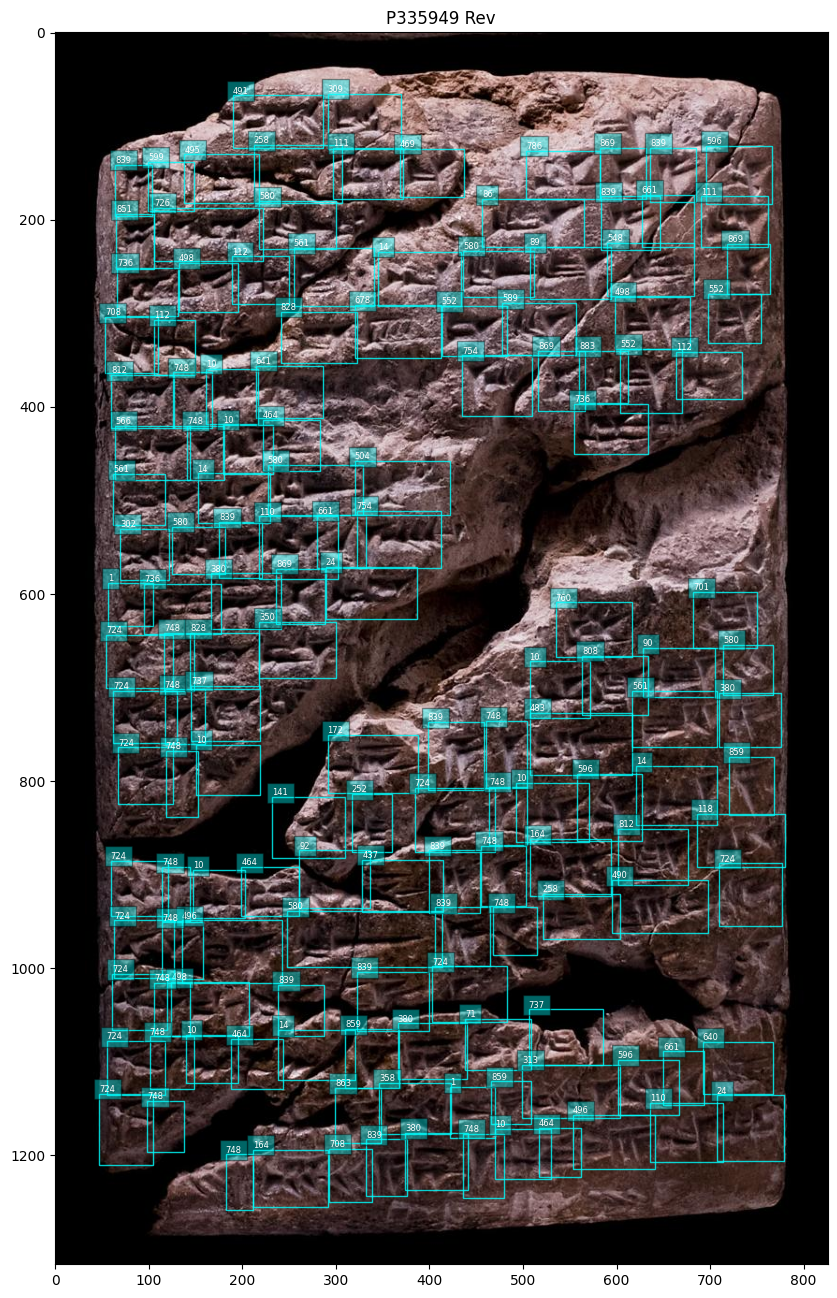

In [ ]:
selected_cdli = 'P335949_Rev'
# P336150_Obv, P336128_Rev, P334932_Rev, P334848_Rev
def view_annotation(anno_df, seg_df, selected_cdli):
    fig, ax = plt.subplots(figsize=(12, 16))

    # select slice from dataframe
    seg_df_slice = seg_df[seg_df.img_name.isin([selected_cdli])]

    # select slice of the dataset corresponding to entries of the selected cdli
    anno_df_slice = anno_df[anno_df.img_name == selected_cdli]

    #print(anno_df_slice)

    path_to_image = '../images/test/{}.jpg'.format(selected_cdli)
    # open tablet image
    pil_im = Image.open(path_to_image)

    # plot segment
    ax.imshow(np.asarray(pil_im))
    ax.set_title("{} {}".format(seg_df_slice.tablet_CDLI.values[0], seg_df_slice.view_desc.values[0]))

    # select annotations
    selected_segm = (anno_df_slice.segm_idx == seg_df_slice.segm_idx.values[0])
    sign_bboxes = np.stack(anno_df_slice[selected_segm].relative_bbox.values)
    sign_lbls = anno_df_slice[selected_segm].mzl_label.values

    # plot boxes
    plot_boxes(sign_bboxes, sign_lbls, ax=ax)

    plt.show()

view_annotation(anno_df, seg_df, selected_cdli)

# EDA

In [212]:
anno_df.head(1)

segm_idx tablet_CDLI view_desc collection  mzl_label  train_label  \
0         8      K08396       Obv       test        252           80   

                   bbox         relative_bbox    img_name  
0  [910, 738, 978, 787]  [504, 655, 572, 704]  K08396_Obv

In [268]:
print(anno_df.shape)
anno_df = anno_df.dropna(subset=['view_desc'])
print(anno_df.shape)

(6727, 9)
(6513, 9)


In [269]:
# num of unique characters 
print(anno_df['train_label'].nunique())
print(anno_df['mzl_label'].nunique())

251
251


In [270]:
# remove rows with mzl_label that map to multiple train_labels
to_remove = anno_df[anno_df['train_label'].map(anno_df.groupby('train_label')['mzl_label'].nunique()) > 1]

columns_to_match = ['mzl_label', 'train_label'] 
anno_df = anno_df.merge(to_remove[columns_to_match], on=columns_to_match, how='left', indicator=True)
anno_df = anno_df[anno_df['_merge'] == 'left_only'].drop(columns=['_merge'])

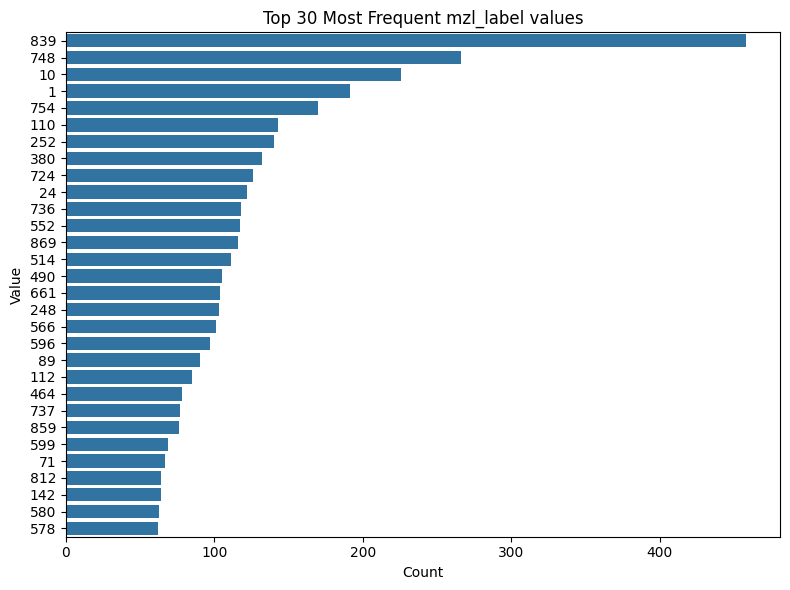

In [271]:
# top 30 most frequent cuneiform characters
top_30 = anno_df['mzl_label'].value_counts().nlargest(30)
plot_df = anno_df[anno_df['mzl_label'].isin(top_30.index)]

plt.figure(figsize=(8, 6))
sns.countplot(data=plot_df, y='mzl_label', order=top_30.index)
plt.title('Top 30 Most Frequent mzl_label values')
plt.xlabel('Count')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [274]:
anno_df['img_name'].nunique()

113

In [278]:
# 118 images, do all them have these 30 signs? 
tablet_check = anno_df.groupby('img_name')['mzl_label'].apply(lambda labels: labels.isin(top_30.index).any())

tablets_with_any_top30 = tablet_check[tablet_check == True].index

print("Tablets with any label in top 30:", len(tablets_with_any_top30))

print(tablets_with_any_top30)

Tablets with any label in top 30: 113
Index(['BM099070_Obv', 'K08396_Obv', 'K08396_Rev', 'ND02486_Obv',
       'ND02486_Rev', 'P239304_Obv', 'P313634_Rev', 'P314346_Obv',
       'P314355_Obv', 'P314355_Rev',
       ...
       'P336678_Rev', 'P336716_Obv', 'P337153_Obv', 'P337153_Rev',
       'P337163_Obv', 'P337163_Rev', 'P393668_Obv', 'P393668_Rev',
       'P404881_Obv', 'P404881_Rev'],
      dtype='object', name='img_name', length=113)


In [283]:
to_remove = [item for item in seg_df['img_name'].unique() if item not in tablets_with_any_top30]

for filename in to_remove:
    filepath = os.path.join('./final_setup/obv_rev_split/', filename + '.jpg')
    if os.path.isfile(filepath):
        os.remove(filepath)
        print(f"Removed: {filepath}")
    else:
        print(f"Not found: {filepath}")

Removed: ./final_setup/obv_rev_split/P335597_Rev.jpg
Removed: ./final_setup/obv_rev_split/P336198_Rev.jpg
Removed: ./final_setup/obv_rev_split/P335941_Rev.jpg
Removed: ./final_setup/obv_rev_split/P336660_Rev.jpg
Removed: ./final_setup/obv_rev_split/P314346_Rev.jpg


['P335597_Rev', 'P336198_Rev', 'P335941_Rev', 'P336660_Rev', 'P314346_Rev']

5 images didnt have any signs, so 113 images contain at least one character from the top 30 list

In [ ]:
# make new annotation file containing only top 30 characters
# 113 images out of 118 contain at least 1 character from top 30 list
df = anno_df[anno_df['mzl_label'].isin(top_30.index)]
df.loc[:, 'bbox'] = df['bbox'].apply(lambda x: str(x.tolist()) if isinstance(x, np.ndarray) else str(x))
df.loc[:, 'relative_bbox'] = df['relative_bbox'].apply(lambda x: str(x.tolist()) if isinstance(x, np.ndarray) else str(x))

df.to_csv('./final_setup/top30_annotations.csv', index=False)

## Find anchor boxes

Faster R-CNN uses anchor boxes as initial bounding box guesses. 

Since the cuneiform characters are small, thin and wide (have unusual aspect ratios) 

Then default anchors (sizes: [32, 64, 128, 256, 512], aspect ratios: [0.5, 1.0, 2.0]) won’t work well.

So we calculate the width, height for our signs

In [ ]:
df = pd.read_csv('./top30_annotations.csv')
#df.bbox = df.bbox.apply(literal_eval).apply(np.array)
#df.relative_bbox = df.relative_bbox.apply(literal_eval).apply(np.array)

In [20]:


def parse_bbox(bbox_str):
    try:
        coords = ast.literal_eval(bbox_str)
        xmin, ymin, xmax, ymax = coords
        width = xmax - xmin
        height = ymax - ymin
        return width, height
    except:
        return None, None

df['width'], df['height'] = zip(*df['relative_bbox'].apply(parse_bbox))
#df.dropna(inplace=True)

df.head(1)


segm_idx tablet_CDLI view_desc collection  mzl_label  train_label  \
0         8      K08396       Obv       test        252           80   

                   bbox         relative_bbox    img_name  width  height  
0  [910, 738, 978, 787]  [504, 655, 572, 704]  K08396_Obv   68.0    49.0

Recommended Anchor Sizes (square root of area): [45, 87, 60, 70, 148]
Recommended Aspect Ratios (h / w): [np.float64(1.07), np.float64(0.62), np.float64(0.67), np.float64(1.19), np.float64(0.72)]


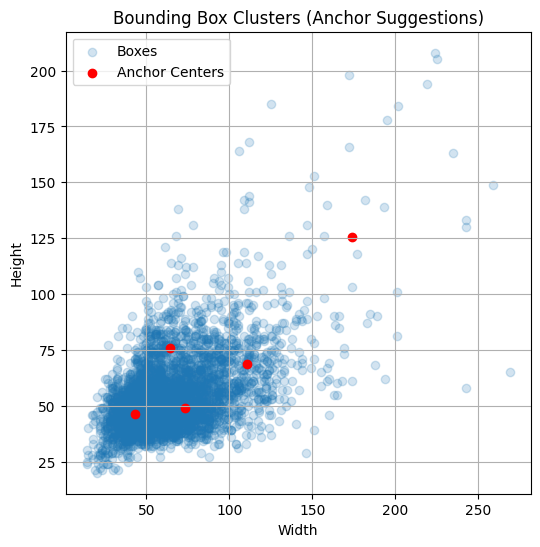

In [ ]:
wh = df[['width', 'height']].to_numpy()

wh = wh[(wh[:, 0] > 1) & (wh[:, 1] > 1)]

k = 5  # Number of anchors to recommend
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(wh)
anchors = kmeans.cluster_centers_

sizes = [round(np.sqrt(w * h)) for w, h in anchors]
aspect_ratios = [round(h / w, 2) for w, h in anchors]

print("Recommended Anchor Sizes (square root of area):", sizes)
print("Recommended Aspect Ratios (h / w):", aspect_ratios)

plt.figure(figsize=(6, 6))
plt.scatter(wh[:, 0], wh[:, 1], alpha=0.2, label="Boxes")
plt.scatter(anchors[:, 0], anchors[:, 1], color='red', label="Anchor Centers")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Anchor Suggestions")
plt.legend()
plt.grid(True)
plt.show()

In [324]:
print(len(df['train_label']))

3741


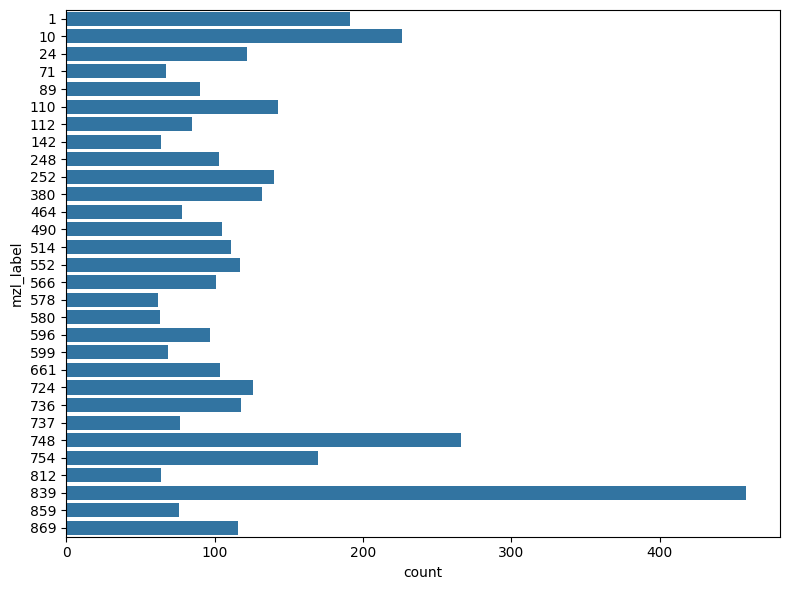

In [50]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='mzl_label')
plt.tight_layout()
plt.show()

In [328]:
df.head(4)

segm_idx tablet_CDLI view_desc collection  mzl_label  train_label  \
0         8      K08396       Obv       test        252           80   
1         8      K08396       Obv       test        252           80   
2         8      K08396       Obv       test        737          100   
3         8      K08396       Obv       test        252           80   

                     bbox         relative_bbox    img_name  
0    [910, 738, 978, 787]  [504, 655, 572, 704]  K08396_Obv  
1  [1235, 526, 1296, 571]  [829, 443, 890, 488]  K08396_Obv  
2    [729, 745, 792, 792]  [323, 662, 386, 709]  K08396_Obv  
3  [1161, 573, 1220, 621]  [755, 490, 814, 538]  K08396_Obv

In [ ]:
view_annotation(df, seg_df, selected_cdli = 'P334311_Obv')

In [ ]:
# df = pd.read_csv("./final_setup/top30_annotations.csv")  # update path if needed

# # Initialize COCO format dictionary
# coco = {
#     "images": [],
#     "annotations": [],
#     "categories": []
# }

# # Assign unique image IDs
# image_id_map = {}
# for i, img_name in enumerate(df['img_name'].unique()):
#     image_id_map[img_name] = i
#     coco['images'].append({
#         "id": i,
#         "file_name": f"{img_name}.jpg"  
#     })

# # Create category list from train_label
# category_id_map = {}
# for i, label in enumerate(sorted(df['mzl_label'].unique())):
#     category_id_map[label] = i
#     coco['categories'].append({
#         "id": i,
#         "name": str(label)  # or use mzl_label if preferred
#     })

# # Create annotations
# annotation_id = 0
# for _, row in df.iterrows():
#     img_id = image_id_map[row['img_name']]
#     cat_id = category_id_map[row['mzl_label']]
#     bbox = ast.literal_eval(row['relative_bbox'])  # convert '[x1, y1, x2, y2]' to list
#     x_min, y_min, x_max, y_max = bbox
#     width = x_max - x_min
#     height = y_max - y_min
#     area = width * height
    
#     coco['annotations'].append({
#         "id": annotation_id,
#         "image_id": img_id,
#         "category_id": cat_id,
#         "bbox": [x_min, y_min, width, height],
#         "area": area,
#         "iscrowd": 0,
#         "segmentation": []  
#     })
#     annotation_id += 1

# # Save to JSON
# output_path = Path("./final_setup/cuneiform_annotations_coco.json")
# with open(output_path, "w") as f:
#     json.dump(coco, f, indent=2)

In [ ]:
image_names = df['img_name'].unique()

# 80/20 train/test split
train_imgs, test_imgs = train_test_split(image_names, test_size=0.2, random_state=42)

train_mask = df['img_name'].isin(train_imgs)
test_mask = df['img_name'].isin(test_imgs)

train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Train/Test Split", dataframe=pd.DataFrame({
#     "Set": ["Train", "Test"],
#     "Images": [len(train_imgs), len(test_imgs)],
#     "Annotations": [len(train_df), len(test_df)]
# }))

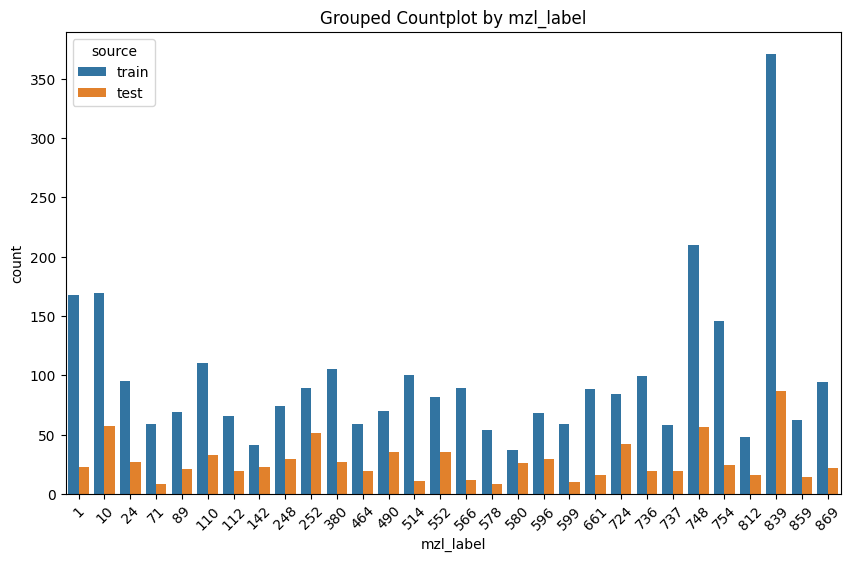

In [ ]:
train_df['source'] = 'train'
test_df['source'] = 'test'

combined_df = pd.concat([train_df, test_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='mzl_label', hue='source')
plt.title("Grouped Countplot by mzl_label")
plt.xticks(rotation=45)
plt.show()

# JSON formatting

In [23]:

# Load the previously created full COCO annotation
with open("./final_setup/cuneiform_annotations_coco.json", "r") as f:
    full_coco = json.load(f)

# Separate image IDs by train/test split
train_image_ids = set(image_id_map[img] for img in train_imgs)
test_image_ids = set(image_id_map[img] for img in test_imgs)

# Function to split coco data
def split_coco(coco_data, image_ids_subset):
    images = [img for img in coco_data['images'] if img['id'] in image_ids_subset]
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids_subset]
    return {
        "images": images,
        "annotations": annotations,
        "categories": coco_data['categories']
    }

# Create train and test coco dictionaries
coco_train = split_coco(full_coco, train_image_ids)
coco_test = split_coco(full_coco, test_image_ids)

# Save to JSON files
train_json_path = Path("./final_setup/train.json")
test_json_path = Path("./final_setup/test.json")

with open(train_json_path, "w") as f:
    json.dump(coco_train, f, indent=2)

with open(test_json_path, "w") as f:
    json.dump(coco_test, f, indent=2)

train_json_path, test_json_path


(PosixPath('final_setup/train.json'), PosixPath('final_setup/test.json'))

In [33]:
# Define paths
source_dir = Path("./final_setup/obv_rev_split")  # Folder with all 113 images
train_dir = Path("./final_setup/train")
test_dir = Path("./final_setup/test")

# Create destination folders if they don't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Move images
for img_name in train_imgs:
    src = source_dir / f"{img_name}.jpg"
    dst = train_dir / f"{img_name}.jpg"
    if src.exists():
        shutil.copy2(str(src), str(dst))

for img_name in test_imgs:
    src = source_dir / f"{img_name}.jpg"
    dst = test_dir / f"{img_name}.jpg"
    if src.exists():
        shutil.copy2(str(src), str(dst))

In [41]:

# Load the JSON file again
input_path = "./final_setup/test_with_size.json"
output_path = "./final_setup/test_with_size_fixed.json"

with open(input_path, 'r') as f:
    data = json.load(f)

# Increment category_id in annotations
for ann in data['annotations']:
    ann['category_id'] += 1

# Increment id in categories
if 'categories' in data:
    for cat in data['categories']:
        cat['id'] += 1

# Save the updated JSON
with open(output_path, 'w') as f:
    json.dump(data, f)

In [42]:

# Load the JSON file again
input_path = "./final_setup/train_with_size.json"
output_path = "./final_setup/train_with_size_fixed.json"

with open(input_path, 'r') as f:
    data = json.load(f)

# Increment category_id in annotations
for ann in data['annotations']:
    ann['category_id'] += 1

# Increment id in categories
if 'categories' in data:
    for cat in data['categories']:
        cat['id'] += 1

# Save the updated JSON
with open(output_path, 'w') as f:
    json.dump(data, f)